In [1]:
# MA Cross Backtesting on 1H BTC on lower granularity
# - Taker fee               is 0.04%
# - Initial capital         is 10000.0$
# - Position size per trade is 2% of account
# - Timeframe               is 1H
# 

In [2]:
import warnings
warnings.filterwarnings("ignore")
def action_with_warnings():
    warnings.warn("should not appear")
with warnings.catch_warnings(record=True):
    action_with_warnings()
import yfinance          as yf
import pandas            as pd
import numpy             as np
import quantstats        as qs
import matplotlib.pyplot as plt

In [3]:
df_ = pd.read_csv("./data/BTCUSDT.csv", parse_dates=True, index_col=0)
df_.index = pd.to_datetime(df_.index, format='mixed')
df_.index = pd.DatetimeIndex(df_.index)
df_

,Open,High,Low,Close,Volume
date,,,,,
2017-08-17 04:00:00,4261.48,4261.48,4261.48,4261.48,1.775183
2017-08-17 04:01:00,4261.48,4261.48,4261.48,4261.48,0.000000
2017-08-17 04:02:00,4280.56,4280.56,4280.56,4280.56,0.261074
2017-08-17 04:03:00,4261.48,4261.48,4261.48,4261.48,0.012008
2017-08-17 04:04:00,4261.48,4261.48,4261.48,4261.48,0.140796
...,...,...,...,...,...
2023-09-30 23:55:00,26967.16,26967.16,26967.15,26967.15,2.068610
2023-09-30 23:56:00,26967.16,26967.16,26964.77,26964.77,2.075120
2023-09-30 23:57:00,26964.77,26964.78,26964.77,26964.77,3.884580


<Axes: xlabel='date'>

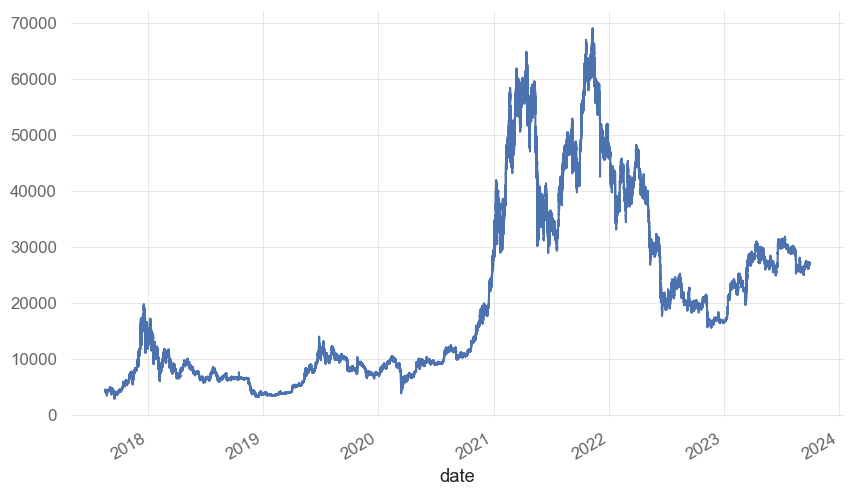

In [4]:
df_['Close'].plot()

In [5]:
hours               = 1
timeframe_by_minute = hours*60
timeframe = f"{timeframe_by_minute}Min"

df = df_.resample(timeframe).agg({'Open':'first', 'High':'max', 'Low':'min', 'Close':'last', 'Volume': 'sum'})
df.dropna(inplace=True) # Dropping because of FX doesn't trade during weekends

df

,Open,High,Low,Close,Volume
date,,,,,
2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009
2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916
2017-08-17 06:00:00,4315.32,4345.45,4309.37,4324.35,7.229691
2017-08-17 07:00:00,4324.35,4349.99,4287.41,4349.99,4.443249
2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807
...,...,...,...,...,...
2023-09-30 19:00:00,26999.98,27037.04,26987.78,27020.70,651.155540
2023-09-30 20:00:00,27020.70,27073.11,27020.69,27064.15,432.671820
2023-09-30 21:00:00,27064.15,27081.78,26946.73,26999.28,650.710080


In [6]:
# Signal extraction

df['MA50' ] = df['Close'].rolling(window=20).mean()
df['MA200'] = df['Close'].rolling(window=50).mean()

df['Signal'] = 0
df.loc[((df['MA50'] > df['MA200']) & (df['MA50'].shift(1) <= df['MA200'].shift(1))), 'Signal'] =  1
df.loc[((df['MA50'] < df['MA200']) & (df['MA50'].shift(1) >= df['MA200'].shift(1))), 'Signal'] = -1

In [7]:
df['Signal'].value_counts()

Signal
 0    52260
 1      637
-1      636
Name: count, dtype: int64

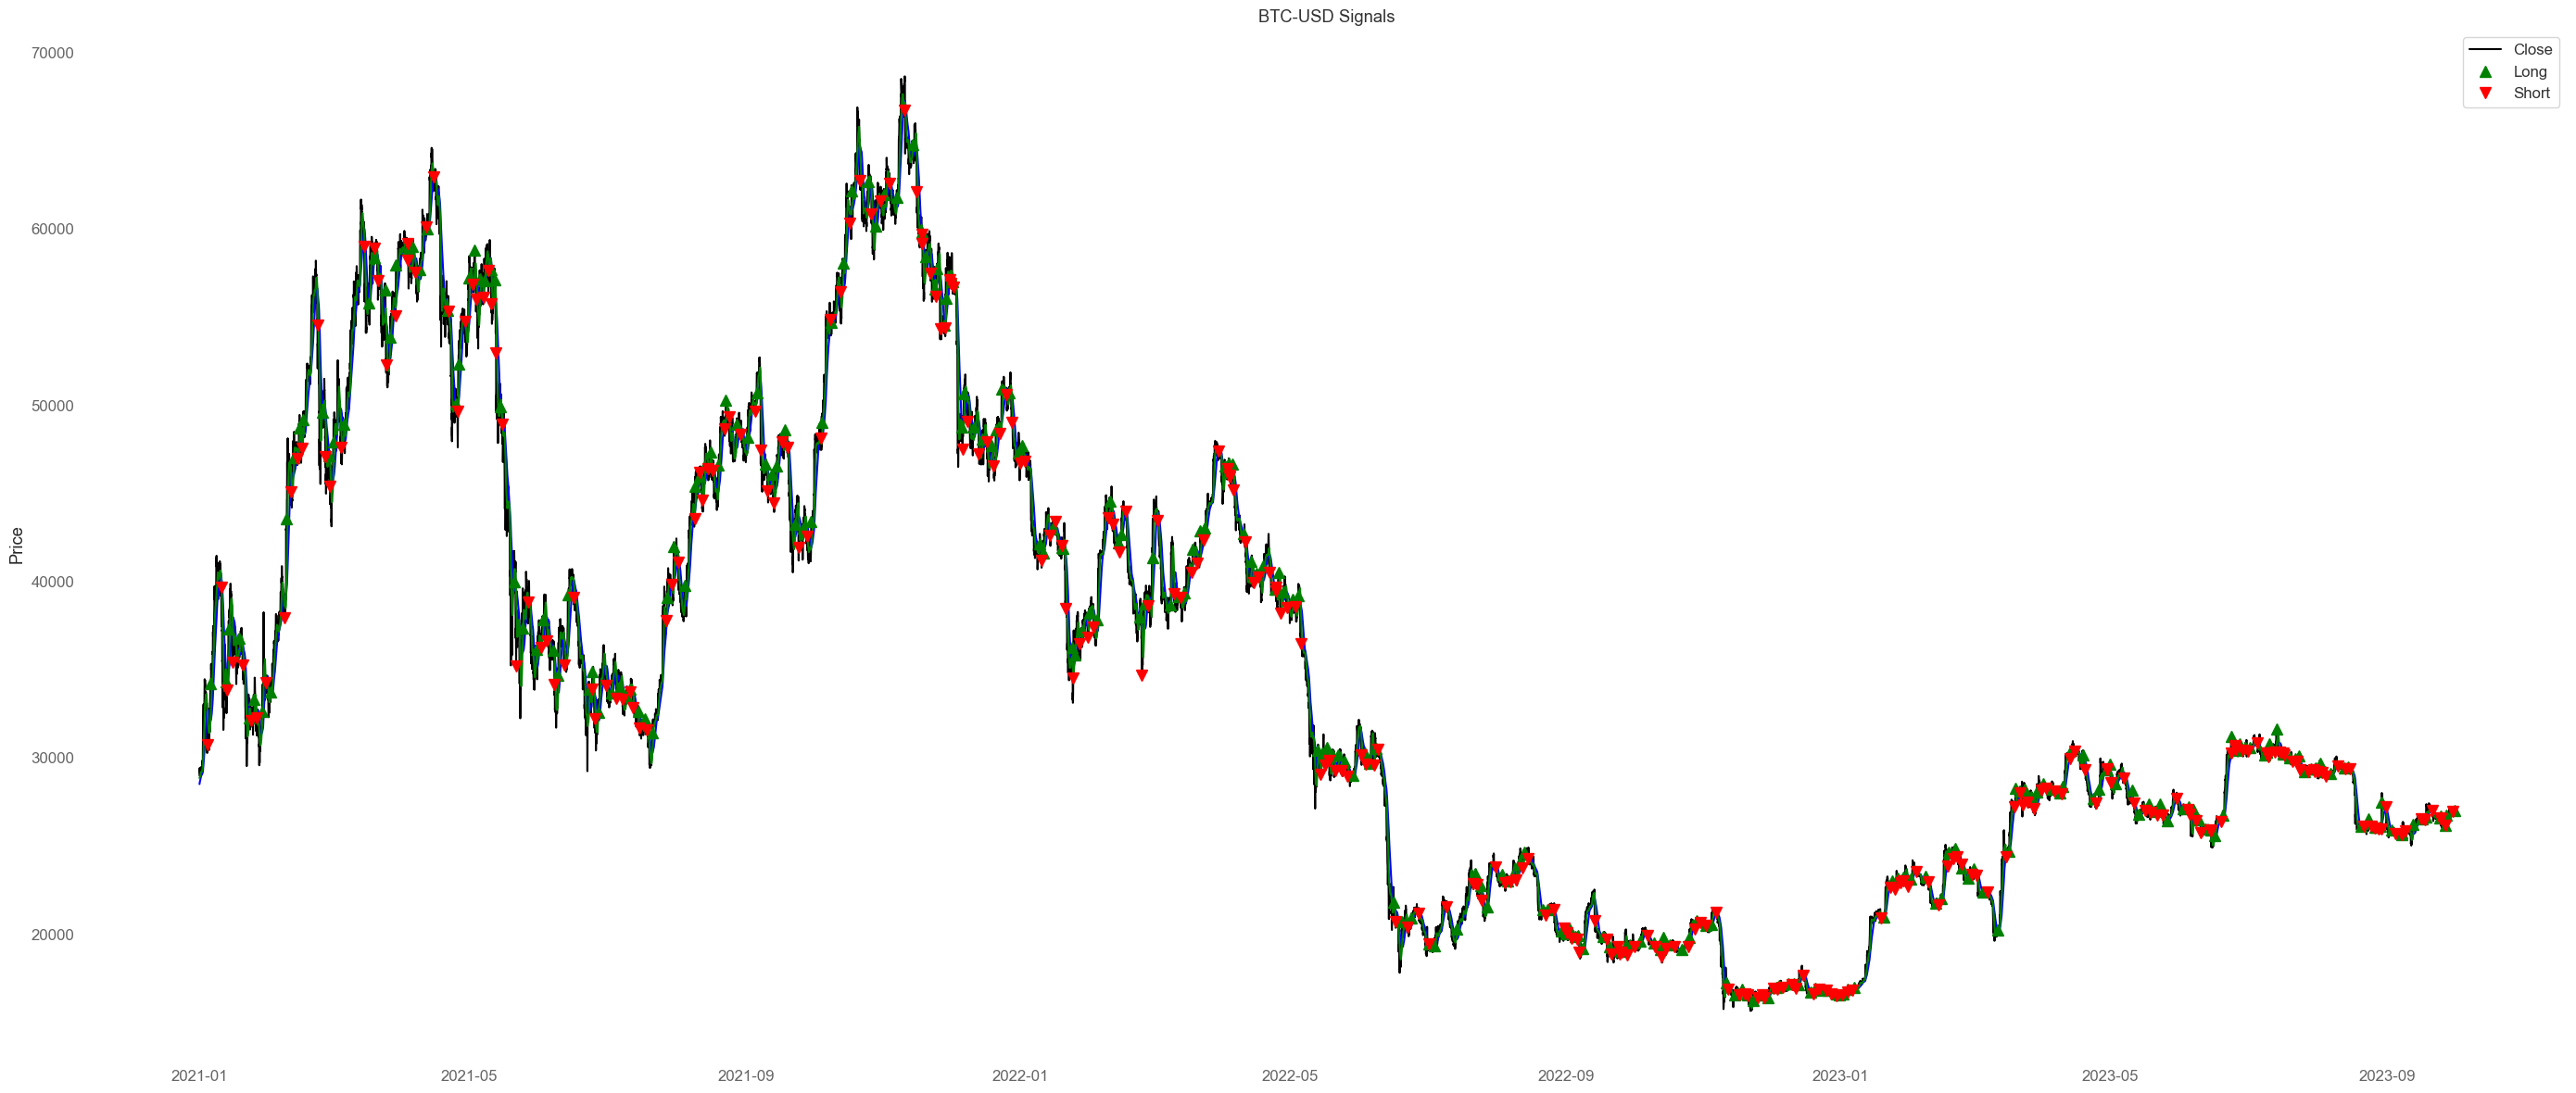

In [8]:
plot_df = df["2021-01-01":]

fig, ax1 = plt.subplots(1, figsize=(28, 12), sharex=True)

ax1.plot(plot_df.index, plot_df['Close'], label='Close', color='black')
ax1.plot(plot_df['MA200'], color='blue' )
ax1.plot(plot_df['MA50' ], color='green')
ax1.plot(plot_df[plot_df['Signal'] ==  1].index, plot_df[plot_df['Signal'] ==  1]['Close'], '^', markersize=8, color='green', label='Long' )
ax1.plot(plot_df[plot_df['Signal'] == -1].index, plot_df[plot_df['Signal'] == -1]['Close'], 'v', markersize=8, color='red'  , label='Short')
ax1.set_ylabel('Price')
ax1.set_title('BTC-USD Signals')
ax1.legend()
ax1.grid()

plt.tight_layout()
plt.show()

In [9]:
# Saving signals extracted on higher timeframe to lower granularity timeframe

df_eval = df_.copy(deep=True)

df_eval['Signal'] = 0

for idx, row in df[df['Signal']== 1].iterrows():
    if idx in df_eval.index:
        df_eval.loc[idx, 'Signal'] = 1

for idx, row in df[df['Signal']==-1].iterrows():
    if idx in df_eval.index:
        df_eval.loc[idx, 'Signal'] = -1

look_ahead_shift = 1
df_eval['Signal' ] = df_eval['Signal' ].shift(hours*60+look_ahead_shift)

df_eval.dropna(inplace=True)

In [10]:
df_eval['Signal'].value_counts()

Signal
 0.0    3209712
 1.0        634
-1.0        632
Name: count, dtype: int64

In [11]:
# Position tracking
position         = 0
entry_timestamp  = None
entry_price      = 0
exit_timestamp   = None
exit_price       = 0
position_history = []

for index, row in df_eval.iterrows():
    if row['Signal'] != position:
        # Exit position
        if position != 0:
            exit_timestamp = index
            exit_price     = row['Close']
            pct_change     = (exit_price - entry_price) / entry_price * 100
            position_history.append((entry_timestamp, exit_timestamp, entry_price, exit_price, pct_change))

        # Enter new position
        if row['Signal'] == 1:
            entry_timestamp = index
            entry_price     = row['Close']

        elif row['Signal'] == -1:
            entry_timestamp = index
            entry_price     = row['Close']

        position = row['Signal']

position_df = pd.DataFrame(position_history, columns=['Entry Time', 'Exit Time', 'Entry Price', 'Exit Price', 'Pct Change'])
position_df['cumret'] = position_df['Pct Change'].cumsum()

In [12]:
initial_capital    = 10000.0 # Initial capital in dollars
commission_fee     = 0.04    # 0.04% commission fee per trade
position_per_trade = 0.02    # 2% of position size per trade

account_balance = initial_capital
balance_changes = []

# Iterate through each trade in the position history
for index, trade in position_df.iterrows():
    pct_change       = trade['Pct Change']
    position_size    = account_balance * position_per_trade
    dollar_change    = position_size * pct_change
    commission       = position_size * (commission_fee/100.0)
    balance_change   = dollar_change - commission
    account_balance += balance_change
    balance_changes.append(balance_change)

position_df['Balance Change'] = balance_changes
position_df['Account History'] = initial_capital + position_df['Balance Change'].cumsum()

position_df['Entry Time'] = pd.to_datetime(position_df['Entry Time'])
position_df = position_df.set_index('Entry Time')

position_df['Account Change'] = position_df['Account History'].pct_change()

In [13]:
position_df

,Exit Time,Entry Price,Exit Price,Pct Change,cumret,Balance Change,Account History,Account Change
Entry Time,,,,,,,,
2017-08-20 14:01:00,2017-08-20 14:02:00,4063.35,4063.35,0.000000,0.000000,-0.080000,9999.920000,NaN
2017-08-21 13:01:00,2017-08-21 13:02:00,4000.00,4000.00,0.000000,0.000000,-0.079999,9999.840001,-0.000008
2017-08-23 04:01:00,2017-08-23 04:02:00,4078.88,4078.88,0.000000,0.000000,-0.079999,9999.760002,-0.000008
2017-08-26 15:01:00,2017-08-26 15:02:00,4274.00,4274.00,0.000000,0.000000,-0.079998,9999.680004,-0.000008
2017-08-27 12:01:00,2017-08-27 12:02:00,4323.37,4323.37,0.000000,0.000000,-0.079997,9999.600006,-0.000008
...,...,...,...,...,...,...,...,...
2023-09-26 21:01:00,2023-09-26 21:02:00,26156.00,26169.07,0.049969,4.485171,10.675603,10779.012239,0.000991
2023-09-26 23:01:00,2023-09-26 23:02:00,26156.02,26156.02,0.000000,4.485171,-0.086232,10778.926007,-0.000008
2023-09-27 12:01:00,2023-09-27 12:02:00,26816.88,26839.99,0.086177,4.571348,18.491693,10797.417700,0.001716


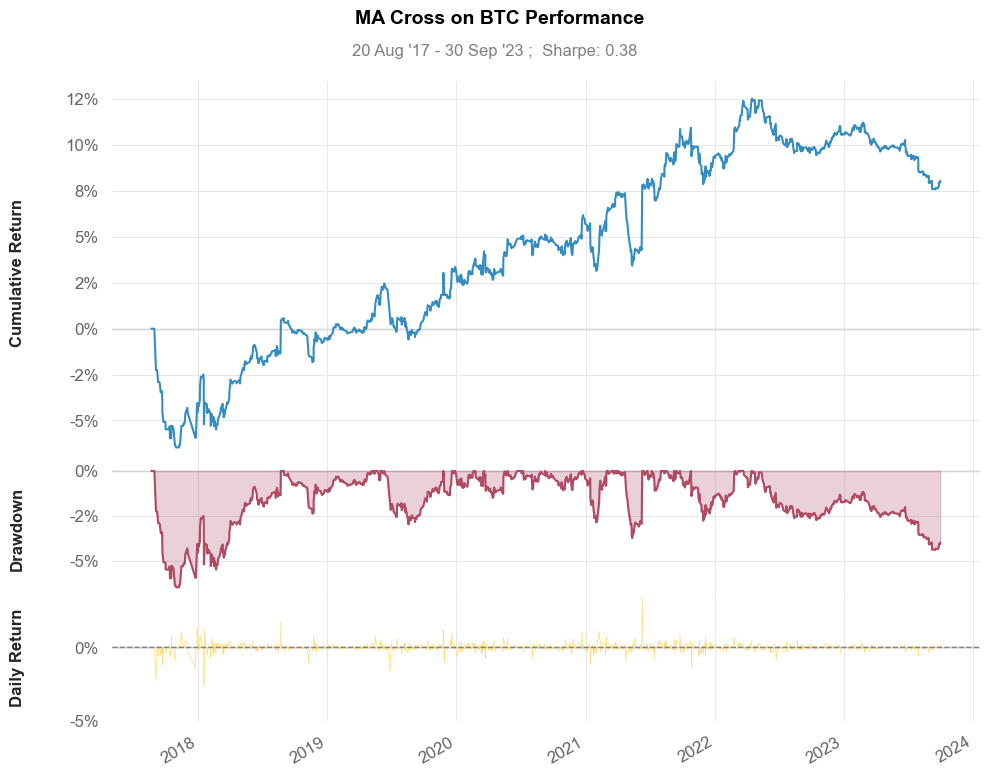

In [14]:
qs.plots.snapshot(position_df['Account Change'], title='MA Cross on BTC Performance', show=True);

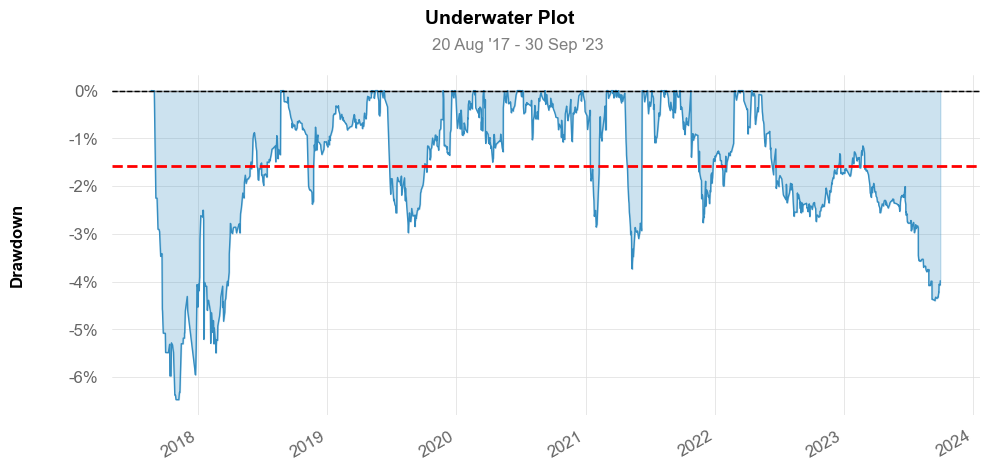

In [15]:
qs.plots.drawdown(position_df['Account Change'])

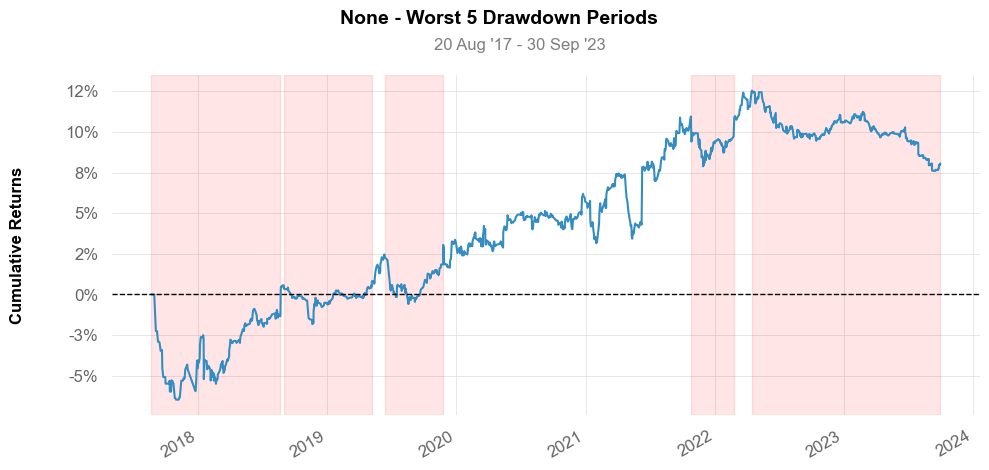

In [16]:
qs.plots.drawdowns_periods(position_df['Account Change'])

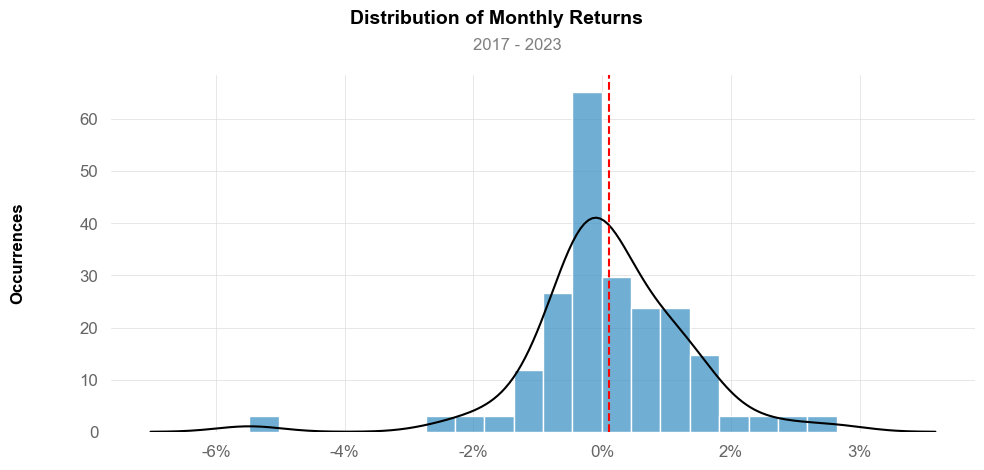

In [17]:
qs.plots.histogram(position_df['Account Change'])

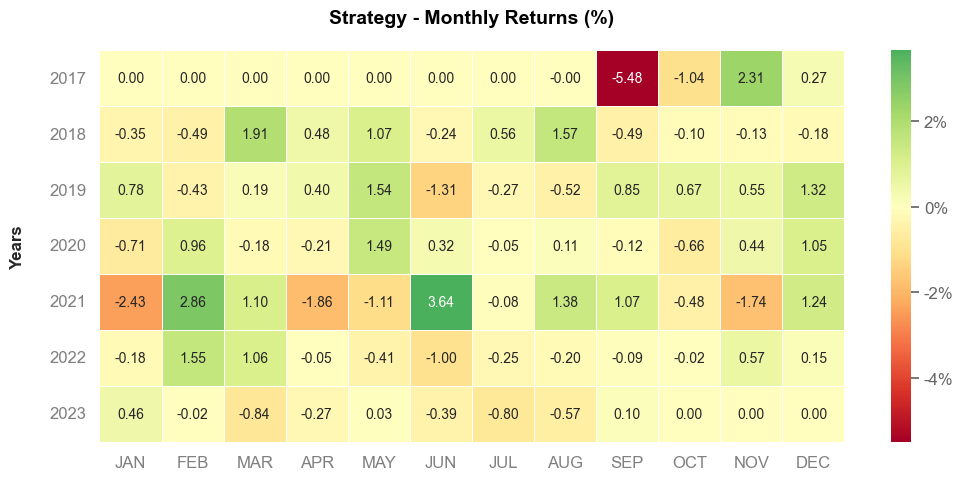

In [18]:
qs.plots.monthly_heatmap(position_df['Account Change'])

In [19]:
qs.stats.sharpe(position_df['Account Change'])

0.3818935479660173

<Axes: xlabel='Entry Time'>

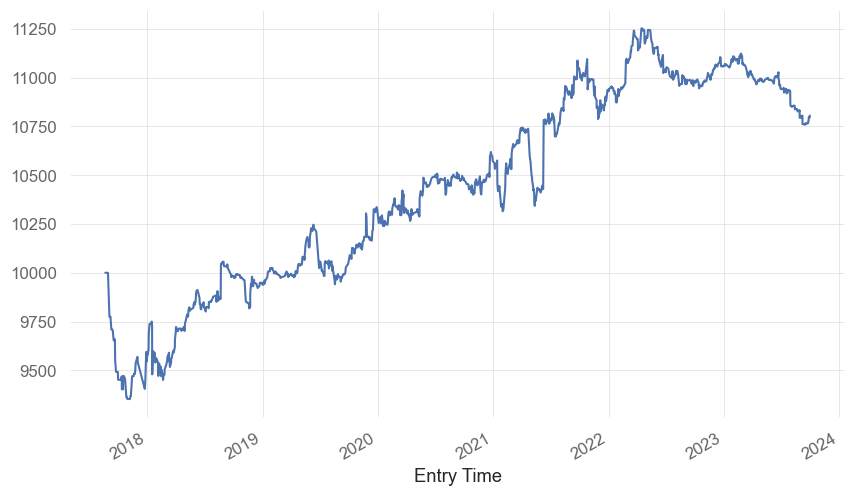

In [20]:
position_df["Account History"].plot()